In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedShuffleSplit

In [59]:
#Load data
train = pd.read_csv('train.csv')
y = train['SalePrice']
train.drop(['Id','SalePrice'],axis = 1,inplace = True)
test = pd.read_csv('test.csv')


In [60]:
##Plot histogram
def numerical_plot(df):
    df.hist(figsize = (25,20))
    plt.show()
#numerical_plot(train)

In [48]:
#PLOT CATEGORICAL DATA AS BARCHARTS
def categorical_plot(df,categorical):   
    for col in categorical:
        data = df[col].value_counts()
        for na in nan_categorical:
            if col == na:
                no_val=df[na].isna().value_counts().rename({True: 'Na value', False : '0'})                
                data = data.append(no_val)
                data = data.drop('0')
        data.plot.bar()
        plt.title(col)
        plt.show()
#categorical_plot(train,categorical)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


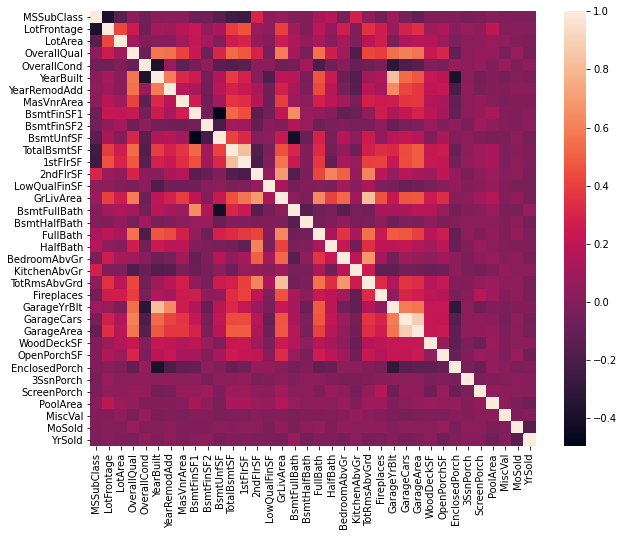

In [61]:
#CORRELATION MATRIX, HEAT MAP AND DATA DESCRIPTION (NUMERICAL)
corr_matrix = train.corr()
#corr_matrix['SalePrice'].sort_values()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix)
train.describe()

In [75]:
#Create a test set stratified related to Overall Qual feature since it is the most correlated variable
def strat_test_set(df):
    df['OverallQual_cat'] = pd.cut(df['OverallQual'],bins = [0,2,4,6,8,np.inf],labels = [1,2,3,4,5])   
    split = StratifiedShuffleSplit(n_splits = 1,test_size = 0.2,random_state = 0)
    for train_index,test_index in split.split(train,train['OverallQual_cat']):
        strat_train_set = train.loc[train_index]
        strat_test_set = train.loc[test_index]
    for set_ in (strat_train_set, strat_test_set,df):
        set_.drop('OverallQual_cat',axis = 1, inplace = True)
    return strat_train_set, strat_test_set
strat_train_set, strat_test_set = strat_test_set(train)


In [68]:
##chech where are the nan values

def nan_cols(df):
    columns_nan = df.isna().sum()
    nan_val = columns_nan.where(columns_nan > 0).dropna()
    return list(nan_val.index)
nan_col = nan_cols(train)

#separate data into categorical and numerical and find where are nan values in each
def separate_data(df):
    categorical = [num for num in df.columns if df.dtypes[num] == 'object']
    numerical = [num for num in df.columns if df.dtypes[num] != 'object']
    return categorical,numerical
categorical, numerical = separate_data(train)

In [69]:
def separate_categorical(df,categorical):##Separate categorical data to use in oneHotEncoder and OrdinalEncoder
    one_enc = []
    ordinal_enc = []
    sub = 'Gd'
    for col in categorical:
        if df[col].str.contains(sub).any() > 0:
            ordinal_enc.append(col)
        else:
            one_enc.append(col)
    remains = ['BsmtFinType2','BsmtFinType1','Utilities','GarageFinish']
    ordinal_enc.extend(remains)
    for i in remains:
        one_enc.remove(i)
    return one_enc, ordinal_enc
one_enc, ordinal_enc = separate_categorical(train,categorical)
  

In [85]:
"""
Data preparation:
     Fill nan values of Electrical feature using SBrkr
     Replace 'none' value with 0 since it represents absence
     Since these last two variables are categorical, they must be remove from the categorical list to perform imputer
     perform a pipeline for numerical data. 1) Fill nan values with median, then perform feature scaling using standard scales
     fit numerical data
     Fill nan values in with 0 for the other categorical variables. 0 represents absence of feature
     fit and transform data to string
     perform ordinal encoding and one hot encoding in certain features selected above as ordinal_enc and one_enc
     transform fitted categorical data to dataframe to append numerical data
"""
def data_preparation(df):   

    df['Electrical'].fillna('SBrkr',inplace = True) #-----> Since SBrkr is the most common value and there is only one NAN
    df['MasVnrType'].replace({'None': 0},inplace =True)#----> Since None represents the absence of Masonry
    elec = pd.DataFrame(df['Electrical'])
    vnr = pd.DataFrame(df['MasVnrType'])


    abs_categorical = categorical.copy()
    abs_categorical.remove('Electrical')
    abs_categorical.remove('MasVnrType')

    numerical_pipeline = Pipeline([
        ('imputer',SimpleImputer(strategy = 'median')),
        ('std_scaler',StandardScaler())
    ])

    numerical_transform = ColumnTransformer([
        ('num',numerical_pipeline,numerical)
    ])

    X_num = numerical_transform.fit_transform(df)

    num_prepared = pd.DataFrame(X_num,columns = numerical)

    cat_transform = ColumnTransformer([
        ('absence_values',SimpleImputer(strategy = 'constant',fill_value = 0),abs_categorical),
    ])

    X_cat = cat_transform.fit_transform(df)
    abs_cat_prepared = pd.DataFrame(X_cat,columns = abs_categorical)
    cat_prepared = pd.concat([abs_cat_prepared,vnr,elec],axis = 1)
    cat_prepared = cat_prepared.applymap(str)
    
    enc_transform = ColumnTransformer([
        ('ordinal',OrdinalEncoder(),ordinal_enc),
        ('one_hot',OneHotEncoder(),one_enc)    
    ])
    final_cat = enc_transform.fit_transform(cat_prepared)
    X_cat_final = pd.DataFrame.sparse.from_spmatrix(final_cat)
    X = pd.concat([X_cat_final,num_prepared],axis = 1)
    
    return X, numerical_pipeline,numerical_transform,cat_transform,enc_transform
X, numerical_pipeline,numerical_transform,cat_transform,enc_transform = data_preparation(strat_test_set)